---
title: Bloch-Redfield and Redfield Failing for degenerate Hamiltonians
date: 2024-08-08
authors:
  - name: Gerardo Suarez
---

### In The SYK model:

In this section we consider the SYK model whose Hamiltonian is given by ([Ryu paper](https://arxiv.org/pdf/2112.13489), [introduction](https://arxiv.org/pdf/2002.12187))

$$H= \sum_{i<j<k<l=1}^{N} J_{i,j,k,l}\psi_{i} \psi_{j} \psi_{k} \psi_{l} $$

Where $J_{i,j,k,l}$ is drawn randomly from a Gaussian ensemble with mean $\mu=0$ and variance $\sigma=\sqrt{3!} \frac{J}{N^{3/2}}$
where J is a constant with dimension of mass. And the $\psi_{i}$ denote the operators of the majorana fermions which are representations
of the clifford algebra. They satisfy

\begin{equation}
\{\psi_{i},\psi_{j}\} = \delta_{i,j}
\end{equation}

For convenience people usually just consider the even case and one dimensional majorana fermions ([appendix A](https://arxiv.org/pdf/2002.12187)). 
We introduce the new basis


$$c_{i}= \frac{1}{\sqrt{2}} (\psi_{2i}-i \psi_{2i+1})$$

$$c_{i}^{\dagger}= \frac{1}{\sqrt{2}} (\psi_{2i}+i \psi_{2i+1})$$

These satisfy

$$\{C_{i},C^{\dagger}_{j}\} = \delta_{i,j}$$
$$\{C_{i}^{\dagger},C_{j}^{\dagger}\} = 0$$

To construct this basis we consider picking a vacuum annhilated by all modes such that 

$$(C_{1}^{\dagger})^{n_{1}} \dots (C_{k}^{\dagger})^{n_{k}} \ket{0 \dots 0} = 0$$

There are $2^{N/2}= 2^{K}$ such states. This is the only irreducible representation of @eq:anti , upn top unitary equailvalence, the representation is given by $2^{k}$ matriceswhich can be found by the recursion relaton

\begin{align}
\psi_{i}^{K} = \psi_{i}^{k-1} \otimes \begin{pmatrix}-1 & 0 \\ 0 &1 \end{pmatrix} \quad \text{for} \quad i=1,2,\dots,N-2 \\
\psi_{N-1}^{K} = \frac{1}{\sqrt{2}} 1_{2^{K-1}} \otimes \begin{pmatrix}0 & 1 \\ 1 &0 \end{pmatrix} \\
\psi_{N}^{K} = \frac{1}{\sqrt{2}} 1_{2^{K-1}} \otimes \begin{pmatrix}0 & -i \\ i &0 \end{pmatrix} 
\end{align}

The superscript $K$ is omitted in the Hamiltonian for convenience. Though not a great example, Let us use $N=2$. To illustrate how solving by Bloch-Redfield may fail

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import ( basis, expect, mesolve, qeye, sigmax, sigmay, sigmaz,destroy,
                   tensor,fidelity,tracedist,brmesolve,Qobj)
from qutip.solver import heom
from scipy.integrate import quad
from pseudomode import pseudomode,zero_temp_bath,rotation
from hamiltonians import syk_full,plot_ground,plot_fidelities,plot_trd,plot_positivity,plot_populations
from nmm import csolve,redfield

In [2]:
N=2
seeds=list(range(42,52))
k=7
H,psis=syk_full(N,seed=seeds[k])

The Hamiltonian in this example is then given  by

In [3]:
H=H/np.max(H.full()) #energy rescaling
H

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[-1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0. -1.]]

While the coupling operator to the bath is simply 

$Q= \sum_{i} a_{i} \psi_{i}$

Where each $a_{i}$ is a real number, randomly generated from a Gaussian

In [4]:
Q=sum([psis[i]*np.sqrt(2) for i in range(len(psis))])
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.+0.j  1.-1.j  1.-1.j  0.+0.j]
 [ 1.+1.j  0.+0.j  0.+0.j -1.+1.j]
 [ 1.+1.j  0.+0.j  0.+0.j  1.-1.j]
 [ 0.+0.j -1.-1.j  1.+1.j  0.+0.j]]

We consider the initial state to be 

In [5]:
N=2
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

In [6]:
E01=H.eigenenergies()[2]-H.eigenenergies()[0]#it is mostly degenerate, this does not help much
w0=1.1 *E01#since I have no g parameter then It doesn't scale uniformingly as ising
gamma=w0/2.05
Gamma=gamma/2
Omega=np.sqrt(w0**2 -Gamma**2)
lam=np.sqrt(Omega)

And consider an underdamped spectral density at zero temperature with $\gamma=${eval}`gamma` , $\lambda=${eval}`lam` ,$\omega_{0}=${eval}`w0`. After fitting the correlation function one obtains

In [7]:
from qutip.core import UnderDampedEnvironment
from qutip.solver.heom import BosonicBath

In [8]:
bath =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
env,fitinfo= bath.approx_by_cf_fit(tfit,Ni_max=1,Nr_max=2,target_rsme=None)
bath=BosonicBath.from_environment(env,Q)
bath.T=0
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-8.71e-02 |-1.92e+00 |4.09e-24                           | 1         |-5.00e-01 |-5.37e-01 |2.13e+00                            
 2         | 5.14e-01 |-5.47e-01 |2.13e+00                           |                                                                      
                                                                     |A normalized RMSE of  4.45e-07 was obtained for the the i

In [9]:
times2 = np.linspace(0,40,500)
cvis = bath.correlation_function(times2)

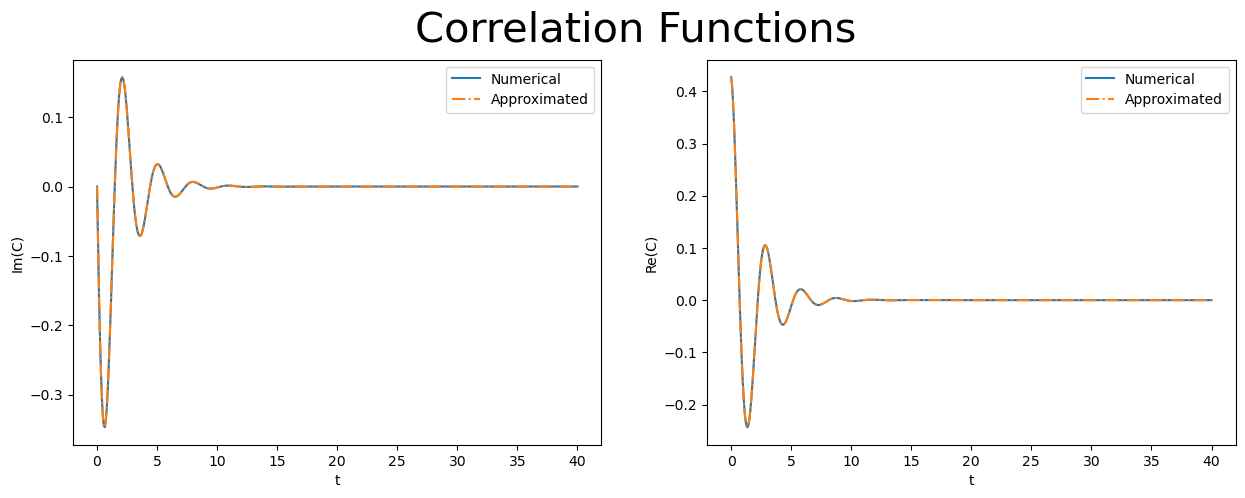

In [10]:
# using the variable axs for multiple Axes
fig, axs = plt.subplots(1, 2,figsize=(15,5))
axs[0].plot(times2, np.imag(cvis),label="Numerical")
axs[0].plot(times2, np.imag(bath.correlation_function(times2)), "-.",label="Approximated")
axs[0].set_xlabel("t")
axs[0].set_ylabel("Im(C)")
axs[0].legend()
axs[1].plot(times2, np.real(cvis),label="Numerical")
axs[1].plot(times2, np.real(bath.correlation_function(times2)), "-.",label="Approximated")
axs[1].set_xlabel("t")
axs[1].set_ylabel("Re(C)")
axs[1].legend()
fig.suptitle('Correlation Functions', fontsize=30)
plt.show()

In [11]:
def solve_dynamics(H,Q,bath,bath1,rho0,depth=8,levels=3,modes=2,times=times):
    print("============================")
    print("Solving HEOM")
    print("============================")
    solver = heom.HEOMSolver(H,
                          [bath1], max_depth=depth, options={"atol": 1e-14})
    result = solver.run(rho0, times)
    print("============================")
    print("HEOM Done")
    print("============================")
    print("============================")
    print("Solving Cumulant")
    print("============================")
    bath.bose=None
    cum = csolve(
        Hsys=H, t=times, baths=[bath],
        Qs=[Q],
        eps=1e-6, cython=False,matsubara=False)
    
    result_cum = cum.evolution(rho0)
    
    result_cum = rotation(result_cum, H, times)
    print("============================")
    print("Cumulant Done")
    print("============================")
    print("============================")
    print("Solving Redfield")
    print("============================")
    red=redfield.redfield(Hsys=H, t=times, baths=[bath1],
    Qs=[Q],
    eps=1e-12,matsubara=True)
    result_red = red.evolution(rho0)
    result_red = [Qobj(i) for i in result_red]
    for i in result_red:
        i.dims=H.dims
    result_red = rotation(result_red, H, times)
    print("============================")
    print("Redfield Done")
    print("============================")
    print("============================")
    print("Solving Bloch-Redfield")
    print("============================")
    a_ops = [[Q, bath]]
    resultBR = brmesolve(H, rho0, times, a_ops=a_ops, options={
        "rtol": 1e-14}, sec_cutoff=-1)
    
    print("============================")
    print("Bloch-Redfield Done")
    print("============================")
    print("============================")
    print("Solving Global")
    print("============================")
    global_one=cum.jump_operators(Q) # Global Jump Operators for Bath 1 2->4
    c_ops2=[Qobj((np.sqrt(bath.power_spectrum(k))*v).data) for k, v in global_one.items()]
    for i in range(len(c_ops2)):
        c_ops2[i].dims=H.dims 
    result_lindblad_global2 = mesolve(H, rho0, times, c_ops2)
    print("============================")
    print("Global Done")
    print("============================")
    # print("============================")
    # print("Solving Pseudomodes")
    # print("============================")
    # Ncutoff=levels
    # bathu = zero_temp_bath(tfit, lam, gamma, w0, N=modes)
    # print(bathu.fitinfo["summary"])
    # example = pseudomode(Hsys=H, Q=Q, bath=bathu)
    # ans = example.evolution(rho0, Ncutoff, times, options={
    #                     "atol": 1e-14, "normalize_output": False, "store_states": True})
    # ans = [i.ptrace(range(N))for i in ans.states]
    # print("============================")
    # print("Pseudomodes done")
    # print("============================")
    results=[result,result_cum,resultBR,result_lindblad_global2,result_red]
    return results

In [12]:
results_syk=solve_dynamics(H,Q,bath,bath,rho0)

Solving HEOM
10.1%. Run time:   1.81s. Est. time left: 00:00:00:16
20.2%. Run time:   2.66s. Est. time left: 00:00:00:10
30.3%. Run time:   3.22s. Est. time left: 00:00:00:07
40.4%. Run time:   3.77s. Est. time left: 00:00:00:05
50.5%. Run time:   4.31s. Est. time left: 00:00:00:04
60.6%. Run time:   4.84s. Est. time left: 00:00:00:03
70.7%. Run time:   5.39s. Est. time left: 00:00:00:02
80.8%. Run time:   5.92s. Est. time left: 00:00:00:01
90.9%. Run time:   6.46s. Est. time left: 00:00:00:00
100.0%. Run time:   6.93s. Est. time left: 00:00:00:00


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Total run time:   6.94s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|██████████████████| 100/100 [00:00<00:00, 1103.49it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.009341955184936523
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.004185676574707031
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:4.819368839263916
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


In [13]:
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()


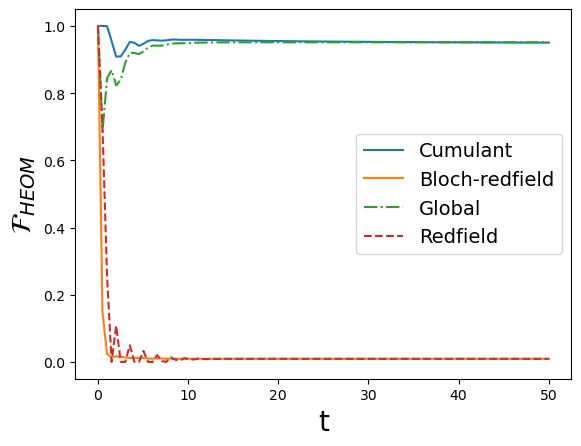

In [14]:
plot_fidelities(results_syk,H,times)

In [15]:
def trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$TR_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
    plt.show()

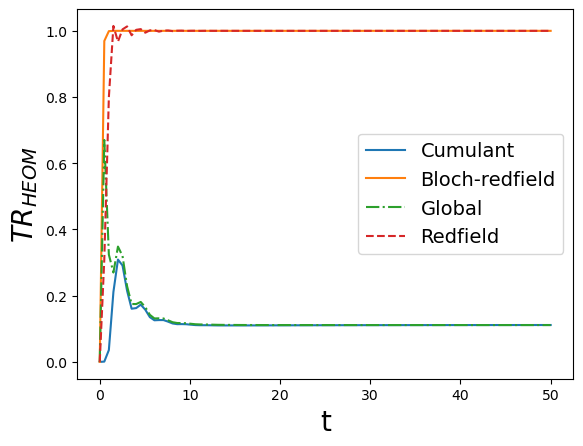

In [16]:
trd(results_syk,H,times)

## Steady states (Not really steady but at $t=50$)

## HEOM

In [17]:
results_syk[0].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.43997328e-01+1.06641092e-16j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.43997328e-01+1.10426629e-16j]
 [ 0.00000000e+00+0.00000000e+00j  5.60026725e-02-7.36002259e-17j
   8.92706245e-17-5.60026725e-02j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.50605424e-16+5.60026725e-02j
   5.60026725e-02+7.80931809e-17j  0.00000000e+00+0.00000000e+00j]
 [-4.43997328e-01-1.23779087e-16j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.43997328e-01-7.64838486e-17j]]

## Cumulant

In [18]:
results_syk[1][-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.99697334e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -4.99697334e-01+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  3.02666160e-04+2.03287907e-19j
   1.76182853e-19-3.02666160e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  1.62630326e-19+3.02666160e-04j
   3.02666160e-04-2.16840434e-19j  0.00000000e+00+0.00000000e+00j]
 [-4.99697334e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.99697334e-01-2.77555756e-17j]]

## Bloch-Redfield

In [19]:
results_syk[2].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.99619058e-01-4.72619518e-18j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.99619058e-01+6.53650885e-19j]
 [ 0.00000000e+00+0.00000000e+00j  3.80942324e-04+2.51985848e-17j
  -2.51985848e-17-3.80942324e-04j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -2.51985848e-17+3.80942324e-04j
   3.80942324e-04-2.51985848e-17j  0.00000000e+00+0.00000000e+00j]
 [ 4.99619058e-01+4.72619518e-18j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.99619058e-01-6.53650885e-19j]]

From what we see in both the trace distance and fidelity plots, the Bloch-Redfield approach does terribly when we consider this scenario (multiple implementations where checked). Notice that this issue seems to be about the coupling operator, rather than the Hamiltonian. 

## Every Equation is ok
Consider a different coupling operator just the majorana fermion denoted by the index 0 coupled to the environment or in the notes notation ($b_{0}=-i$,$b_{1}=0$)

In [20]:
Q2=psis[0]*np.sqrt(2)
Q2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]]

In [21]:
bath = UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
env,fitinfo= bath.approx_by_cf_fit(tfit,Ni_max=1,Nr_max=2,target_rsme=None)
bath=BosonicBath.from_environment(env,Q2)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-8.71e-02 |-1.92e+00 |4.09e-24                           | 1         |-5.00e-01 |-5.37e-01 |2.13e+00                            
 2         | 5.14e-01 |-5.47e-01 |2.13e+00                           |                                                                      
                                                                     |A normalized RMSE of  4.45e-07 was obtained for the the i

In [22]:
results_syk2=solve_dynamics(H,Q2,bath,bath,rho0,modes=3)

Solving HEOM
10.1%. Run time:   2.27s. Est. time left: 00:00:00:20
20.2%. Run time:   4.04s. Est. time left: 00:00:00:15
30.3%. Run time:   5.88s. Est. time left: 00:00:00:13
40.4%. Run time:   7.49s. Est. time left: 00:00:00:11
50.5%. Run time:   8.96s. Est. time left: 00:00:00:08
60.6%. Run time:  10.36s. Est. time left: 00:00:00:06
70.7%. Run time:  11.75s. Est. time left: 00:00:00:04
80.8%. Run time:  13.16s. Est. time left: 00:00:00:03
90.9%. Run time:  14.99s. Est. time left: 00:00:00:01
100.0%. Run time:  16.77s. Est. time left: 00:00:00:00
Total run time:  16.77s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 313.49it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.019316434860229492
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.005938291549682617
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:2.124385356903076
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


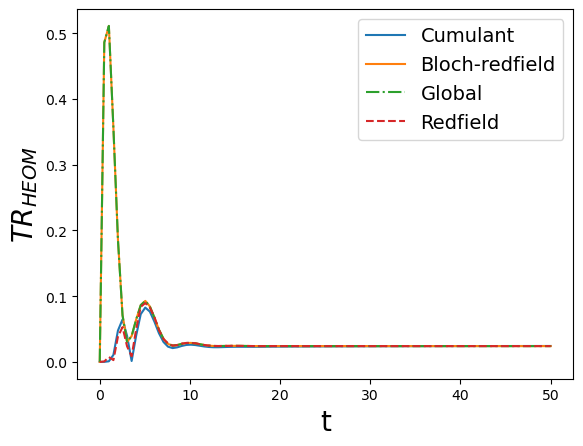

In [23]:
trd(results_syk2,H,times)

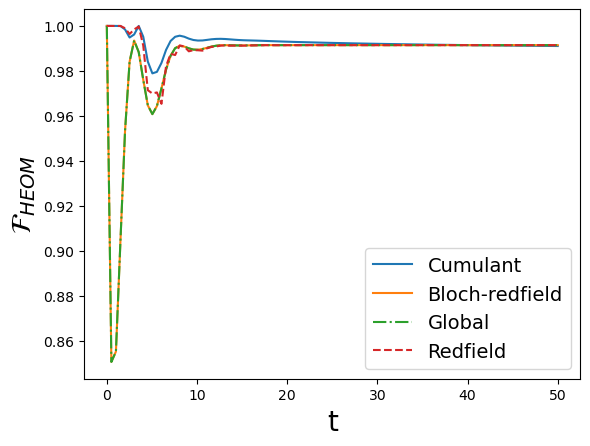

In [24]:
plot_fidelities(results_syk2,H,times)

I observe the same behaviour in many spin chain configurations for large $N$

# Cumulant and global failing (What I didn't see before)

Another example ($b_{0}=-i$,$b_{1}=-i$)

In [25]:
Q3=psis[0]*np.sqrt(2)*1j + psis[2]*np.sqrt(2)
Q3

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=False
Qobj data =
[[ 0.+0.j  1.+0.j  0.-1.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+1.j]
 [ 0.+1.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.-1.j -1.+0.j  0.+0.j]]

In [26]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-8.71e-02 |-1.92e+00 |4.09e-24                           | 1         |-5.00e-01 |-5.37e-01 |2.13e+00                            
 2         | 5.14e-01 |-5.47e-01 |2.13e+00                           |                                                                      
                                                                     |A normalized RMSE of  4.45e-07 was obtained for the the i

In [27]:
results_syk3=solve_dynamics(H,Q3,bath,bath,rho0,modes=3)

Solving HEOM
10.1%. Run time:   0.32s. Est. time left: 00:00:00:02
20.2%. Run time:   0.55s. Est. time left: 00:00:00:02
30.3%. Run time:   0.80s. Est. time left: 00:00:00:01
40.4%. Run time:   1.07s. Est. time left: 00:00:00:01
50.5%. Run time:   1.32s. Est. time left: 00:00:00:01
60.6%. Run time:   1.53s. Est. time left: 00:00:00:00
70.7%. Run time:   1.83s. Est. time left: 00:00:00:00
80.8%. Run time:   2.08s. Est. time left: 00:00:00:00
90.9%. Run time:   2.30s. Est. time left: 00:00:00:00
100.0%. Run time:   2.49s. Est. time left: 00:00:00:00
Total run time:   2.49s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|██████████████████| 100/100 [00:00<00:00, 1477.32it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.010901927947998047
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.008633136749267578
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:0.307544469833374
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


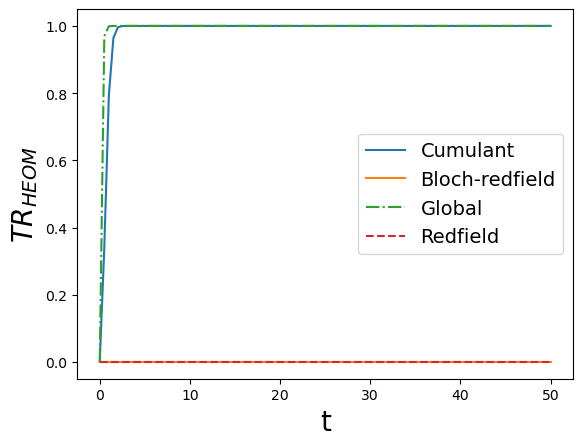

In [28]:
trd(results_syk3,H,times)

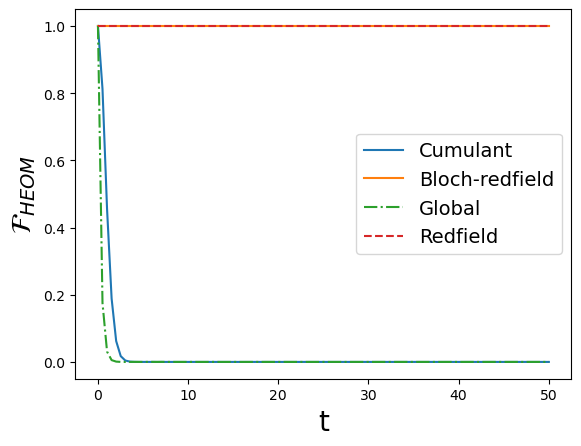

In [29]:
plot_fidelities(results_syk3,H,times)

 ## Heom Steady

In [30]:
results_syk3[0].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

## Global Steady

In [31]:
results_syk3[3].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 5.00000001e-01+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  0.00000000e+00+5.00000001e-01j]
 [ 0.00000000e+00+0.00000000e+00j -7.62898328e-10+0.00000000e+00j
   0.00000000e+00+7.62898328e-10j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j  0.00000000e+00-7.62898328e-10j
  -7.62898328e-10+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00-5.00000001e-01j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  5.00000001e-01+0.00000000e+00j]]

# Different initial state

To make things more confusing let us consider a different initial state and see how things work, and then don't

But it does definitely seems to have something to do with ergodicity

In [32]:
N=2
state_list = [basis(2, 0)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 0)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = tensor(state_list)
rho02=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)
rho02

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

We use the first coupling operator

In [33]:
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.+0.j  1.-1.j  1.-1.j  0.+0.j]
 [ 1.+1.j  0.+0.j  0.+0.j -1.+1.j]
 [ 1.+1.j  0.+0.j  0.+0.j  1.-1.j]
 [ 0.+0.j -1.-1.j  1.+1.j  0.+0.j]]

In [34]:
bath=BosonicBath.from_environment(env,Q)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])
results_syk4=solve_dynamics(H,Q,bath,bath,rho02)

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-8.71e-02 |-1.92e+00 |4.09e-24                           | 1         |-5.00e-01 |-5.37e-01 |2.13e+00                            
 2         | 5.14e-01 |-5.47e-01 |2.13e+00                           |                                                                      
                                                                     |A normalized RMSE of  4.45e-07 was obtained for the the i

Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 462.62it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.011409997940063477
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.0045337677001953125
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:4.3189308643341064
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


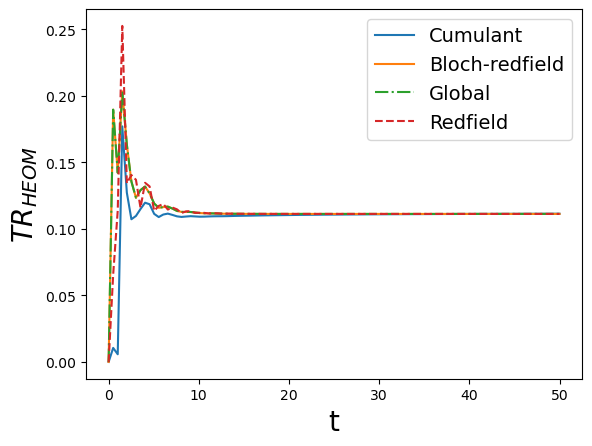

In [35]:
trd(results_syk4,H,times)

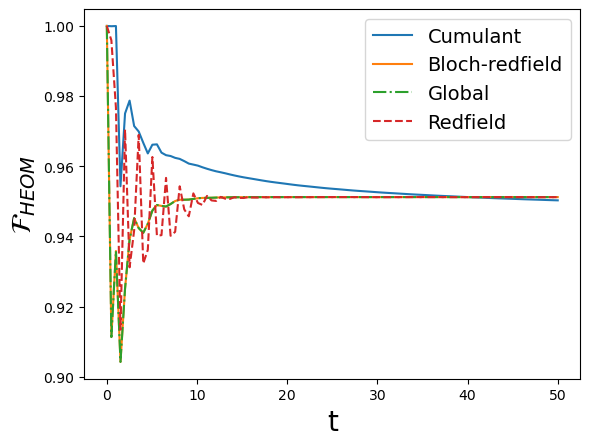

In [36]:
plot_fidelities(results_syk4,H,times)

In [37]:
Q2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]]

In [38]:
bath=BosonicBath.from_environment(env,Q2)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])
results_syk5=solve_dynamics(H,Q2,bath,bath,rho02)

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-8.71e-02 |-1.92e+00 |4.09e-24                           | 1         |-5.00e-01 |-5.37e-01 |2.13e+00                            
 2         | 5.14e-01 |-5.47e-01 |2.13e+00                           |                                                                      
                                                                     |A normalized RMSE of  4.45e-07 was obtained for the the i

Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 476.98it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.007914304733276367
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.005281686782836914
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:1.6650292873382568
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


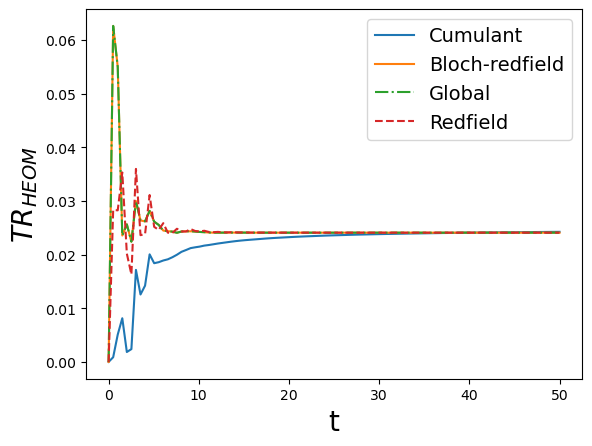

In [39]:
trd(results_syk5,H,times)

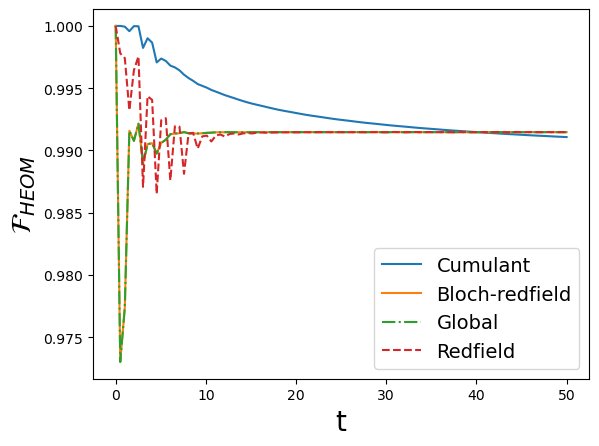

In [40]:
plot_fidelities(results_syk5,H,times)

In [41]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=0
# notice one mode is also a pretty good approximation
print(fitinfo['summary'])
results_syk6=solve_dynamics(H,Q3,bath,bath,rho02)

Correlation function fit:

Result of fitting the real part of                                   |Result of fitting the imaginary part                                  
the correlation function with 2 terms:                               |of the correlation function with 1 terms:                             
                                                                     |                                                                      
 Parameters|    a     |    b     |    c                              | Parameters|    a     |    b     |    c                               
 1         |-8.71e-02 |-1.92e+00 |4.09e-24                           | 1         |-5.00e-01 |-5.37e-01 |2.13e+00                            
 2         | 5.14e-01 |-5.47e-01 |2.13e+00                           |                                                                      
                                                                     |A normalized RMSE of  4.45e-07 was obtained for the the i

Computing Exponential of Generators . . . .: 100%|██████████████████| 100/100 [00:00<00:00, 1509.95it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.009934663772583008
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.004271745681762695
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:2.9280617237091064
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


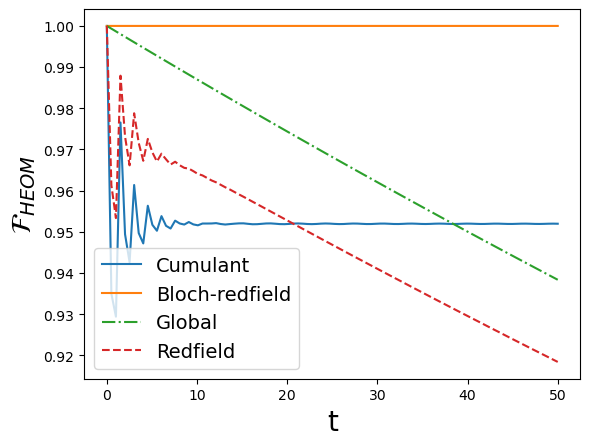

In [42]:
plot_fidelities(results_syk6,H,times)

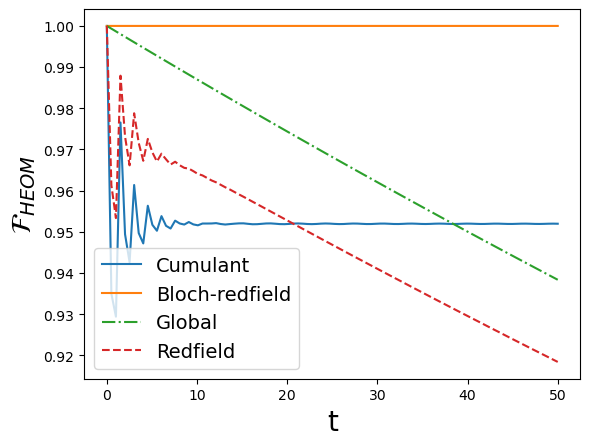

In [43]:
plot_fidelities(results_syk6,H,times)

# Finite Temperature

For Finite Temperature I find the exact same behaviour
$T=1$

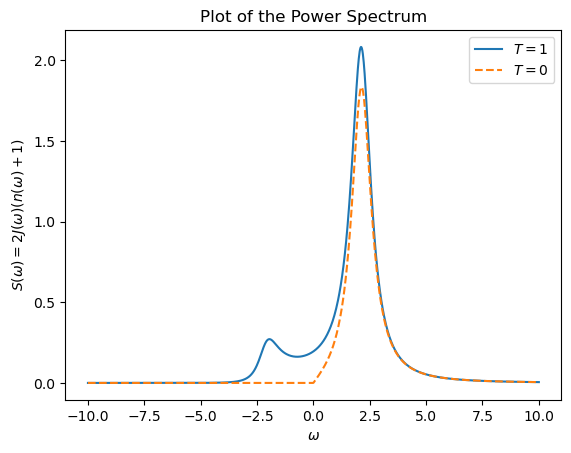

In [44]:
bath1 =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=1) # fix runtime warning
bath2 =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=0) # fix runtime warning
w=np.linspace(-10,10,1000)
plt.plot(w,bath1.power_spectrum(w),label=r"$T=1$")
plt.plot(w,bath2.power_spectrum(w),"--",label=r"$T=0$")
plt.ylabel(r"$S(\omega)=2 J(\omega) (n(\omega)+1)$")
plt.xlabel(r"$\omega$")
plt.title("Plot of the Power Spectrum")
plt.legend()
plt.show()

We use the first initial state

In [45]:
N=2
state_list = [basis(2, 1)] + [-1j*basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list2 = [basis(2, 1)] + [basis(2, 0)] * (N - 1) # change the initial state to be away from the ground state
state_list.reverse()
psi0 = (tensor(state_list)+tensor(state_list2))/np.sqrt(2)
rho0=psi0*psi0.dag()
H.dims=rho0.dims
Q.dims=rho0.dims
times=np.linspace(0,50,100)
tfit=np.linspace(0, 80, 5000)
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

In [46]:
bath =UnderDampedEnvironment(lam=lam, gamma=gamma, w0=w0, T=1) # fix runtime warning
env= bath.approx_by_matsubara(Nk=5)
bath=BosonicBath.from_environment(env,Q)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk7=solve_dynamics(H,Q,bath,bath,rho0)

Solving HEOM
10.1%. Run time:  29.30s. Est. time left: 00:00:04:20
20.2%. Run time:  58.68s. Est. time left: 00:00:03:51
30.3%. Run time:  90.94s. Est. time left: 00:00:03:29
40.4%. Run time: 121.43s. Est. time left: 00:00:02:59
50.5%. Run time: 152.48s. Est. time left: 00:00:02:29
60.6%. Run time: 182.94s. Est. time left: 00:00:01:58
70.7%. Run time: 213.37s. Est. time left: 00:00:01:28
80.8%. Run time: 244.89s. Est. time left: 00:00:00:58
90.9%. Run time: 274.96s. Est. time left: 00:00:00:27
100.0%. Run time: 307.56s. Est. time left: 00:00:00:00
Total run time: 307.56s
HEOM Done
Solving Cumulant


Calculating Integrals ...:   0%|                                                  | 0/4 [00:00<?, ?it/s]/home/mcditoos/qutip_gsoc_app/qutip/utilities.py:53: RuntimeWarning: overflow encountered in exp
  result[non_zero] = 1 / (np.exp(w[non_zero] / w_th) - 1)
Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 769.41it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.007655143737792969
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.00435948371887207
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:4.4576098918914795
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


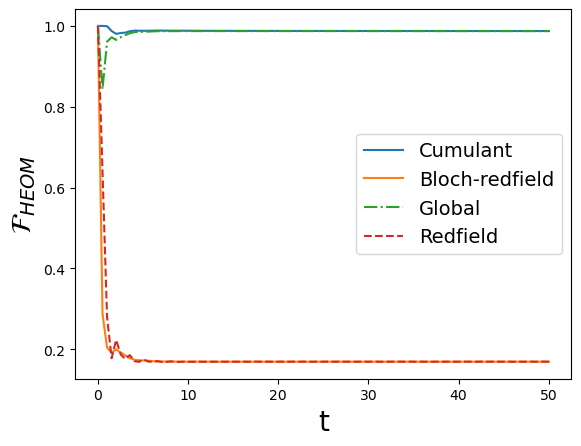

In [47]:
plot_fidelities(results_syk7,H,times)

### Steady state from HEOM

In [48]:
results_syk7[0].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 3.79746669e-01+2.04177986e-16j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j -3.79746669e-01+7.32828632e-17j]
 [ 0.00000000e+00+0.00000000e+00j  1.20253331e-01-1.09725190e-16j
  -2.13508996e-17-1.20253331e-01j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -7.86664194e-17+1.20253331e-01j
   1.20253331e-01-7.83773253e-17j  0.00000000e+00+0.00000000e+00j]
 [-3.79746669e-01-8.16670318e-17j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  3.79746669e-01+2.08615697e-17j]]

### Steady state from BR

In [49]:
results_syk7[2].states[-1]

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[ 4.40396598e-01-1.14741735e-09j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.40396582e-01+1.38837259e-09j]
 [ 0.00000000e+00+0.00000000e+00j  5.96034104e-02+9.26780327e-09j
  -9.26780327e-09-5.96034104e-02j  0.00000000e+00+0.00000000e+00j]
 [ 0.00000000e+00+0.00000000e+00j -6.73201355e-09+5.96034102e-02j
   5.96034102e-02-6.73201355e-09j  0.00000000e+00+0.00000000e+00j]
 [ 4.40396598e-01+1.14741735e-09j  0.00000000e+00+0.00000000e+00j
   0.00000000e+00+0.00000000e+00j  4.40396582e-01-1.38837259e-09j]]

In [50]:
bath=BosonicBath.from_environment(env,Q2)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk8=solve_dynamics(H,Q2,bath,bath,rho0)

Solving HEOM
10.1%. Run time:  19.58s. Est. time left: 00:00:02:54
20.2%. Run time:  39.54s. Est. time left: 00:00:02:36
30.3%. Run time:  59.63s. Est. time left: 00:00:02:17
40.4%. Run time:  80.49s. Est. time left: 00:00:01:58
50.5%. Run time:  99.47s. Est. time left: 00:00:01:37
60.6%. Run time: 119.82s. Est. time left: 00:00:01:17
70.7%. Run time: 139.88s. Est. time left: 00:00:00:57
80.8%. Run time: 160.08s. Est. time left: 00:00:00:38
90.9%. Run time: 180.12s. Est. time left: 00:00:00:18
100.0%. Run time: 197.47s. Est. time left: 00:00:00:00
Total run time: 197.47s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 290.81it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.011978626251220703
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.004902362823486328
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:1.580270528793335
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


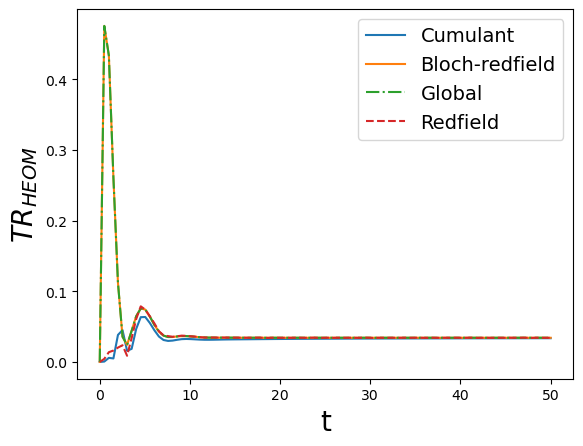

In [51]:
trd(results_syk8,H,times)

In [52]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk9=solve_dynamics(H,Q3,bath,bath,rho0)

Solving HEOM
10.1%. Run time:   4.63s. Est. time left: 00:00:00:41
20.2%. Run time:   8.13s. Est. time left: 00:00:00:32
30.3%. Run time:  12.49s. Est. time left: 00:00:00:28
40.4%. Run time:  17.30s. Est. time left: 00:00:00:25
50.5%. Run time:  21.08s. Est. time left: 00:00:00:20
60.6%. Run time:  24.84s. Est. time left: 00:00:00:16
70.7%. Run time:  28.48s. Est. time left: 00:00:00:11
80.8%. Run time:  32.04s. Est. time left: 00:00:00:07
90.9%. Run time:  35.70s. Est. time left: 00:00:00:03
100.0%. Run time:  39.15s. Est. time left: 00:00:00:00
Total run time:  39.15s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 884.52it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.009831428527832031
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.004579782485961914
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:0.3135547637939453
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


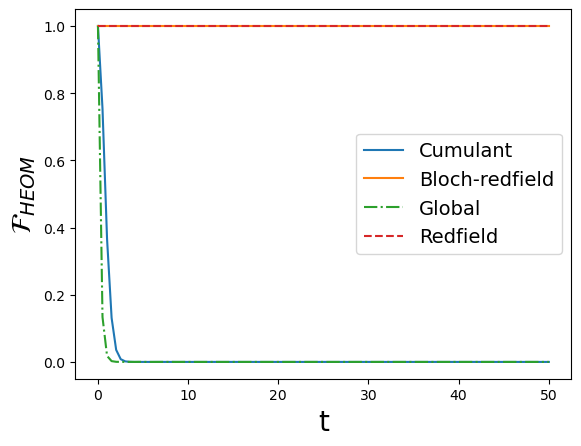

In [53]:
plot_fidelities(results_syk9,H,times)

In [54]:
bath=BosonicBath.from_environment(env,Q)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk10=solve_dynamics(H,Q,bath,bath,rho02)

Solving HEOM
10.1%. Run time:  74.45s. Est. time left: 00:00:11:02
20.2%. Run time: 139.35s. Est. time left: 00:00:09:10
30.3%. Run time: 202.36s. Est. time left: 00:00:07:45
40.4%. Run time: 271.83s. Est. time left: 00:00:06:40
50.5%. Run time: 338.55s. Est. time left: 00:00:05:31
60.6%. Run time: 405.52s. Est. time left: 00:00:04:23
70.7%. Run time: 468.27s. Est. time left: 00:00:03:13
80.8%. Run time: 531.18s. Est. time left: 00:00:02:06
90.9%. Run time: 605.36s. Est. time left: 00:00:01:00
100.0%. Run time: 671.20s. Est. time left: 00:00:00:00
Total run time: 671.20s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 446.65it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.020970821380615234
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.00602412223815918
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:5.44212007522583
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


In [55]:
bath=BosonicBath.from_environment(env,Q2)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk11=solve_dynamics(H,Q2,bath,bath,rho02)

Solving HEOM
10.1%. Run time:  48.86s. Est. time left: 00:00:07:14
20.2%. Run time:  99.10s. Est. time left: 00:00:06:31
30.3%. Run time: 154.17s. Est. time left: 00:00:05:54
40.4%. Run time: 203.57s. Est. time left: 00:00:05:00
50.5%. Run time: 260.22s. Est. time left: 00:00:04:15
60.6%. Run time: 310.31s. Est. time left: 00:00:03:21
70.7%. Run time: 359.61s. Est. time left: 00:00:02:28
80.8%. Run time: 409.88s. Est. time left: 00:00:01:37
90.9%. Run time: 459.00s. Est. time left: 00:00:00:45
100.0%. Run time: 503.23s. Est. time left: 00:00:00:00
Total run time: 503.23s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 215.36it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.013356208801269531
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.00950765609741211
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:1.4473235607147217
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


In [56]:
bath=BosonicBath.from_environment(env,Q3)
bath.T=1
# notice one mode is also a pretty good approximation
results_syk12=solve_dynamics(H,Q3,bath,bath,rho02)

Solving HEOM
10.1%. Run time:   8.97s. Est. time left: 00:00:01:19
20.2%. Run time:  16.93s. Est. time left: 00:00:01:06
30.3%. Run time:  25.02s. Est. time left: 00:00:00:57
40.4%. Run time:  32.95s. Est. time left: 00:00:00:48
50.5%. Run time:  41.45s. Est. time left: 00:00:00:40
60.6%. Run time:  50.13s. Est. time left: 00:00:00:32
70.7%. Run time:  59.36s. Est. time left: 00:00:00:24
80.8%. Run time:  67.83s. Est. time left: 00:00:00:16
90.9%. Run time:  75.17s. Est. time left: 00:00:00:07
100.0%. Run time:  81.89s. Est. time left: 00:00:00:00
Total run time:  81.89s
HEOM Done
Solving Cumulant


Computing Exponential of Generators . . . .: 100%|███████████████████| 100/100 [00:00<00:00, 681.47it/s]


Cumulant Done
Solving Redfield
Started integration and Generator Calculations
Finished integration and Generator Calculations
Computation Time:0.008646965026855469
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started interpolation
Finished interpolation
Computation Time:0.004553556442260742
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Started Solving the differential equation
Finished Solving the differential equation
Computation Time:3.436411142349243
Redfield Done
Solving Bloch-Redfield
Bloch-Redfield Done
Solving Global
Global Done


# Summary

The effect happens for both finite and zero temperature, it depends on the coupling operator and the initial state mostly

In [57]:
def create_subplot_figure(plot_functions,array ,titles, figsize=(15, 5), layout=None):
    """
    Create a figure with subplots from individual plotting functions
    
    Parameters:
    - plot_functions: List of functions that create plots (each ending with plt.show())
    - titles: List of titles for each subplot
    - figsize: Overall figure size
    - layout: Tuple of (rows, columns) for subplot arrangement. If None, tries to make a square-like grid
    """
    # Determine layout if not specified
    if layout is None:
        n = len(array)
        rows = 1
        cols = 3
        layout = (rows, cols)
    
    # Create figure
    fig, axes = plt.subplots(layout[0], layout[1], figsize=figsize)
    
    
    # Iterate through plotting functions
    for k,i in enumerate(array):
        # Temporarily change current axis
        plt.sca(axes[k] if len(array) > 1 else axes)
        
        # Call the plotting function
        plot_functions(i,H,times)
        
        # Set title
        axes[k].set_title(titles[k]) if len(array) > 1 else plt.title(title)
    
    # Remove extra subplots if any
    if len(array) < len(axes):
        for j in range(len(array), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

The Coupling operators are:

$Q_{1}$

In [58]:
Q

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.+0.j  1.-1.j  1.-1.j  0.+0.j]
 [ 1.+1.j  0.+0.j  0.+0.j -1.+1.j]
 [ 1.+1.j  0.+0.j  0.+0.j  1.-1.j]
 [ 0.+0.j -1.-1.j  1.+1.j  0.+0.j]]

$Q_{2}$

In [59]:
Q2

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=True
Qobj data =
[[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
 [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
 [0.+0.j 0.+0.j 0.+1.j 0.+0.j]]

$Q_{3}$

In [60]:
Q3

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=CSR, isherm=False
Qobj data =
[[ 0.+0.j  1.+0.j  0.-1.j  0.+0.j]
 [-1.+0.j  0.+0.j  0.+0.j  0.+1.j]
 [ 0.+1.j  0.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.-1.j -1.+0.j  0.+0.j]]

For the initial state

In [61]:
rho0

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0. +0.j  0. +0.j  0. +0.j  0. +0.j ]
 [0. +0.j  0.5+0.j  0. -0.5j 0. +0.j ]
 [0. +0.j  0. +0.5j 0.5+0.j  0. +0.j ]
 [0. +0.j  0. +0.j  0. +0.j  0. +0.j ]]

### At $T=0$

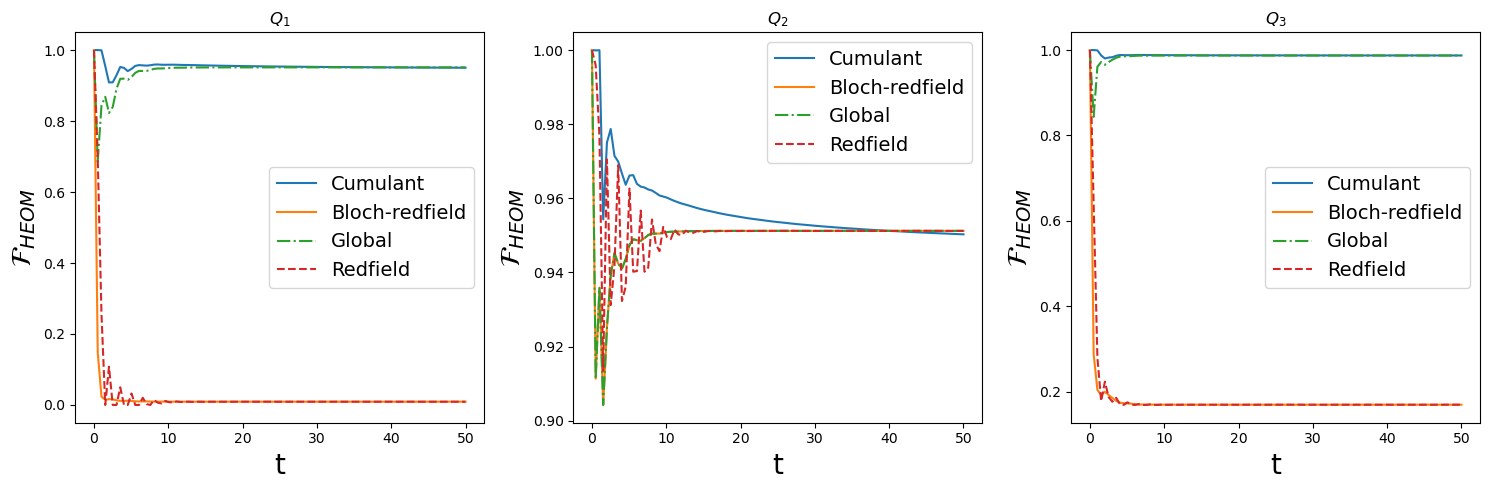

In [62]:
def trd(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([tracedist(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([tracedist(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$TR_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
def plot_fidelities(states,H,times):
    labels=["HEOM","Cumulant","Bloch-redfield","Global","Redfield","Pseudomodes"]
    style=["solid","solid","solid","dashdot",'dashed',"solid"]
    for k,i in enumerate(states[1:],1):
        try:
            sdd=np.array([fidelity(i.states[j],states[0].states[j]) for j in range(len(times))])
        except:
            sdd=np.array([fidelity(i[j],states[0].states[j]) for j in range(len(times))])
        plt.plot(times,sdd,label=labels[k],linestyle=style[k])
    plt.legend(fontsize=14)
    plt.ylabel(r"$\mathcal{F}_{HEOM}$",fontsize=20)
    plt.xlabel(r"t",fontsize=20)
create_subplot_figure(plot_fidelities,[results_syk,results_syk4,results_syk7],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])

### Finite Temperature

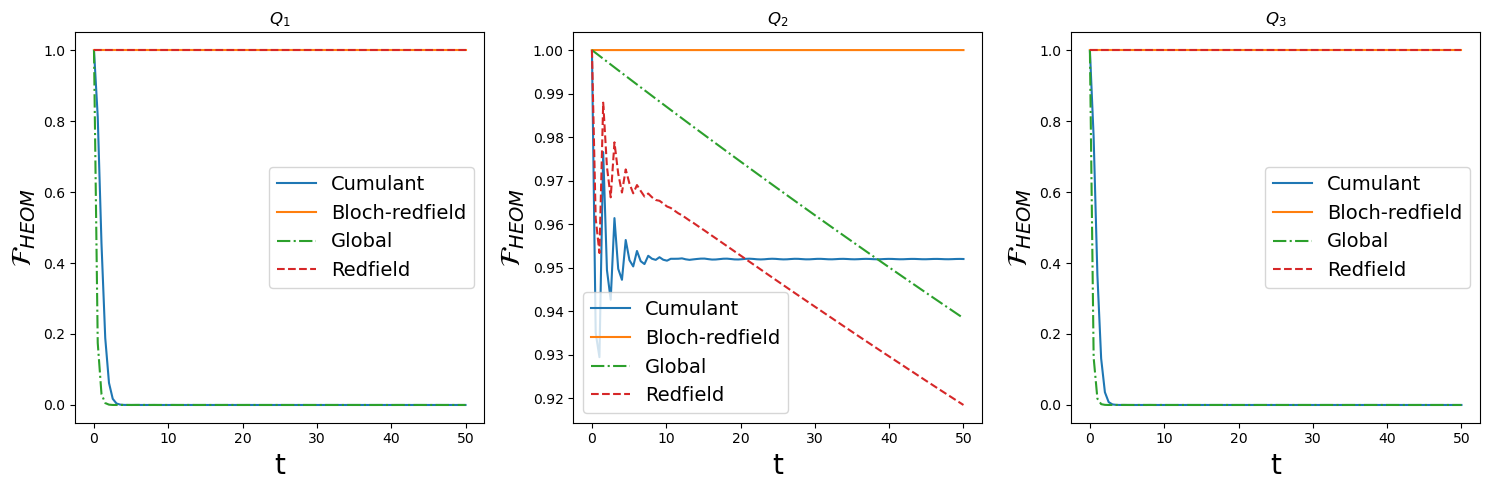

In [63]:
create_subplot_figure(plot_fidelities,[results_syk3,results_syk6,results_syk9],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])

## For the initial state

In [64]:
rho02

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

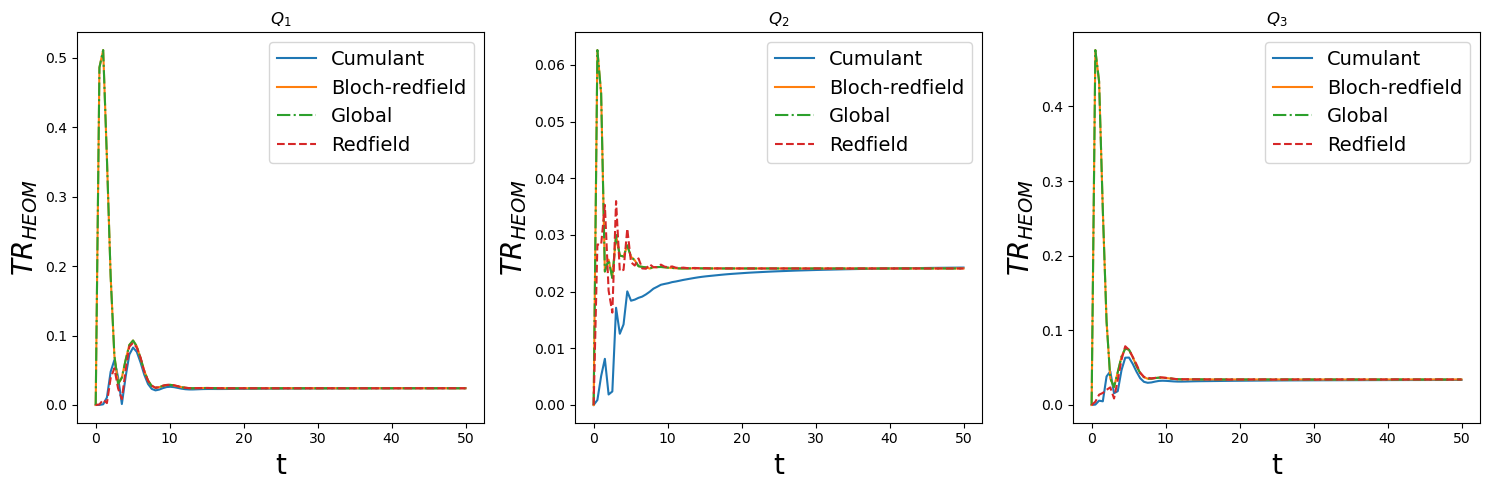

In [65]:
create_subplot_figure(trd,[results_syk2,results_syk5,results_syk8],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])

### Finite Temperature

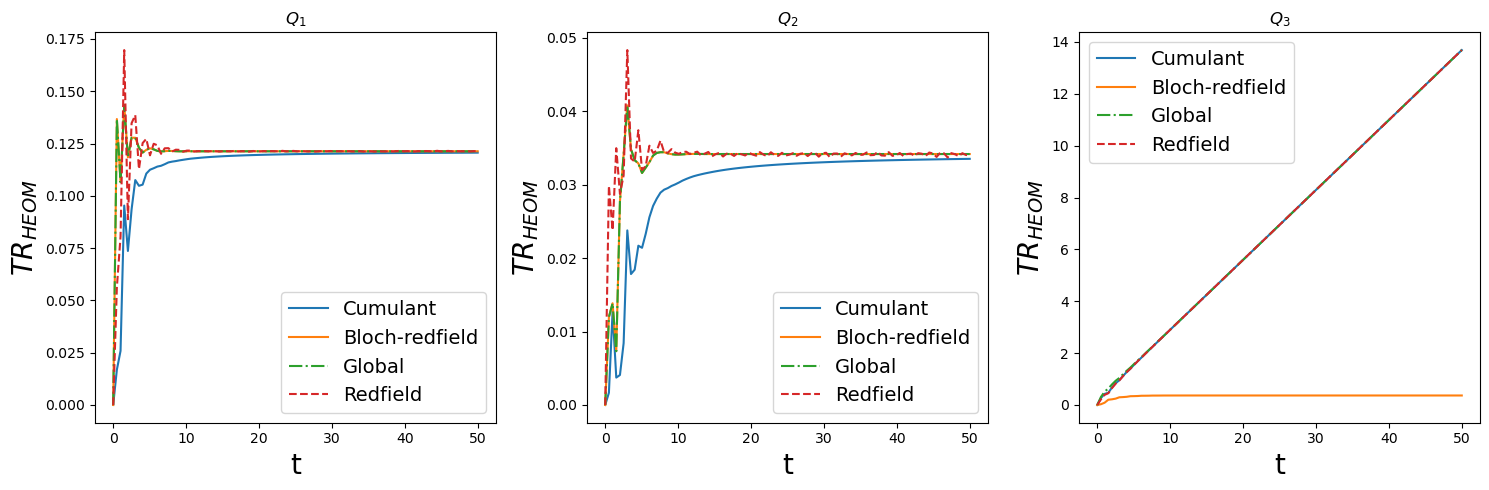

In [66]:
create_subplot_figure(trd,[results_syk10,results_syk11,results_syk12],
[r"$Q_{1}$",r"$Q_{2}$",r"$Q_{3}$"])